In [11]:
import os
import librosa
import numpy as np
import pandas as pd



In [12]:
def extract_emotion_from_filename(filename):
    try:
        emotion_code = filename.split('-')[2]
        emotion_mapping = {
            '01': 'Neutral',
            '02': 'Calm',
            '03': 'Happy',
            '04': 'Sad',
            '05': 'Angry',
            '06': 'Fearful',
            '07': 'Disgust',
            '08': 'Surprised'
        }
        return emotion_mapping.get(emotion_code, 'Unknown')
    except IndexError:
        print(f"Filename format error: {filename}")
        return 'Unknown'


In [13]:
def add_noise(y, noise_level=0.005):
    noise = np.random.normal(0, 1, len(y))
    return y + noise_level * noise



In [14]:
def extract_features_from_audio(y, sr, filename):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    pitch, _ = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch[pitch > 0]) if pitch[pitch > 0].size > 0 else 0
    
    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)
    
    zcr = librosa.feature.zero_crossing_rate(y=y)
    zcr_mean = np.mean(zcr)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    tonnetz_mean = np.mean(tonnetz, axis=1) if tonnetz.shape[1] > 0 else np.zeros(6)
    
    emotion = extract_emotion_from_filename(filename)
    
    return np.hstack([
        mfccs_mean, pitch_mean, rmse_mean, zcr_mean, spectral_rolloff_mean,
        chroma_mean, spectral_centroid_mean, spectral_bandwidth_mean,
        tempo, tonnetz_mean
    ]), emotion


In [15]:
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1]  # You can tweak these

ravdess_folder = '/Users/eliasskau/Artificial Intelligence/Audio-data'  # Your audio path

for nl in noise_levels:
    print(f"Processing noise level {nl}...")
    audio_features = []

    for actor_folder in os.listdir(ravdess_folder):
        if 'Actor_' in actor_folder:
            actor_path = os.path.join(ravdess_folder, actor_folder)
            for audio_file in os.listdir(actor_path):
                if audio_file.endswith(".wav"):
                    audio_path = os.path.join(actor_path, audio_file)
                    y, sr = librosa.load(audio_path, sr=48000)
                    y_noisy = add_noise(y, noise_level=nl)
                    features, emotion = extract_features_from_audio(y_noisy, sr, audio_file)
                    audio_features.append(np.append(features, emotion))


    # Define feature columns
    feature_columns = [f"MFCC_{i+1}" for i in range(13)] + ['Pitch', 'Energy', 'ZCR', 'Spectral_Rolloff'] + \
    [f"Chroma_{i+1}" for i in range(12)] + ['Spectral_Centroid', 'Spectral_Bandwidth', 'Tempo'] + \
    [f"Tonnetz_{i+1}" for i in range(6)] + ['Emotion']
    # Create and save DataFrame
    features_df = pd.DataFrame(audio_features, columns=feature_columns)
    features_df.to_csv(f"ravdess_features_noisy_{nl}.csv", index=False)
    print(f"Saved: ravdess_features_noisy_{nl}.csv")


Processing noise level 0.005...
Saved: ravdess_features_noisy_0.005.csv
Processing noise level 0.01...
Saved: ravdess_features_noisy_0.01.csv
Processing noise level 0.02...
Saved: ravdess_features_noisy_0.02.csv
Processing noise level 0.05...
Saved: ravdess_features_noisy_0.05.csv
Processing noise level 0.1...
Saved: ravdess_features_noisy_0.1.csv


In [21]:
correlation_df = pd.DataFrame(index=features)
df_clean = pd.read_csv("ravdess_audio_features_all.csv")


for nl in noise_levels:
    df_noisy = pd.read_csv(f"ravdess_features_noisy_{nl}.csv")
    correlations = [
        df_clean[feat].corr(df_noisy[feat]) for feat in features
    ]
    correlation_df[f"Noise_{nl}"] = correlations


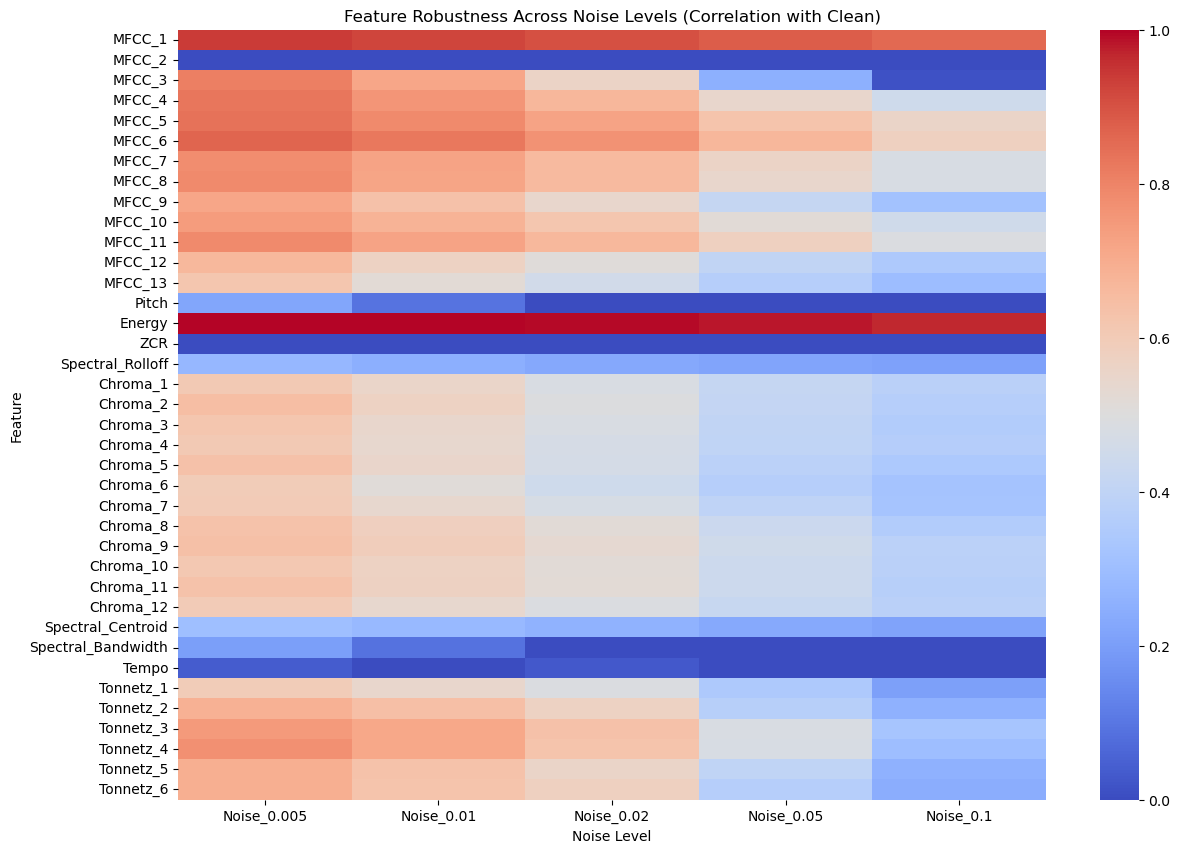

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_df, annot=False, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Feature Robustness Across Noise Levels (Correlation with Clean)")
plt.xlabel("Noise Level")
plt.ylabel("Feature")
plt.show()


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_clean = df_clean[features]
y_clean = df_clean["Emotion"]

accuracies = []

for nl in noise_levels:
    df_noisy = pd.read_csv(f"ravdess_features_noisy_{nl}.csv")
    X_noisy = df_noisy[features]
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_clean, y_clean)
    acc = accuracy_score(y_clean, clf.predict(X_noisy))
    accuracies.append(acc)


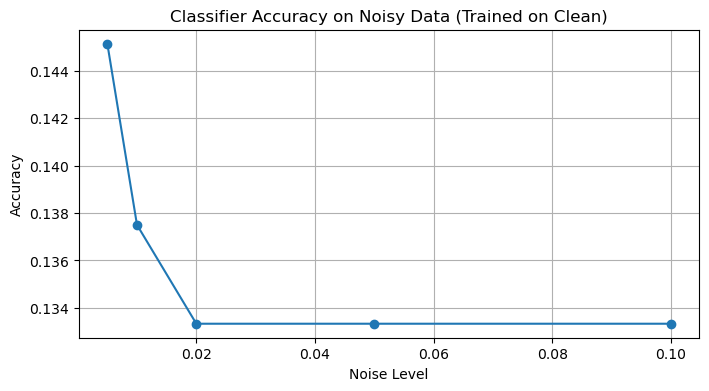

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(noise_levels, accuracies, marker='o')
plt.title("Classifier Accuracy on Noisy Data (Trained on Clean)")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


# Graph

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define your noise levels (excluding clean initially)
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1]
features = None  # We'll set this after loading clean data


In [38]:
# Load clean data
df_clean = pd.read_csv("ravdess_audio_features_all.csv")
features = df_clean.columns[:-1]
X_clean = df_clean[features]
y_clean = df_clean["Emotion"]

# Consistent split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

# Train clean-only model
clf_clean = RandomForestClassifier(random_state=42)
clf_clean.fit(X_train_clean, y_train_clean)


RandomForestClassifier(random_state=42)

In [39]:
# Load and stack all noisy data
df_all = df_clean.copy()

for nl in noise_levels:
    df_noise = pd.read_csv(f"ravdess_features_noisy_{nl}.csv")
    df_all = pd.concat([df_all, df_noise], ignore_index=True)

X_all = df_all[features]
y_all = df_all["Emotion"]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Train all-data model
clf_all = RandomForestClassifier(random_state=42)
clf_all.fit(X_train_all, y_train_all)


RandomForestClassifier(random_state=42)

In [40]:
# Evaluate all models on CLEAN data (Noise = 0)
acc_clean_trained = [accuracy_score(y_test_clean, clf_clean.predict(X_test_clean))]
acc_noisy_trained = []  # We'll insert at index 0 later
acc_all_trained = [accuracy_score(y_test_clean, clf_all.predict(X_test_clean))]

# TEMP: dummy for noisy model at noise=0 (we'll train one inside loop on noisy data)
acc_noisy_clean = None


In [49]:
# Reset the accuracy lists
acc_clean_trained = [accuracy_score(y_test_clean, clf_clean.predict(X_test_clean))]
acc_noisy_trained = []  # we'll insert acc_noisy_clean at the end of the loop
acc_all_trained = [accuracy_score(y_test_clean, clf_all.predict(X_test_clean))]

# Temporary: will store noisy-trained model's accuracy on clean test set
acc_noisy_clean = None

for nl in noise_levels:
    df_noisy = pd.read_csv(f"ravdess_features_noisy_{nl}.csv")
    X_noisy = df_noisy[features]
    y_noisy = df_noisy["Emotion"]

    # Stratified split (same seed)
    X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(
        X_noisy, y_noisy, test_size=0.2, stratify=y_noisy, random_state=42
    )

    # Train noisy-only model
    clf_noisy = RandomForestClassifier(random_state=42)
    clf_noisy.fit(X_train_noisy, y_train_noisy)

    # Save noisy model's performance on clean test set (once)
    if acc_noisy_clean is None:
        acc_noisy_clean = accuracy_score(y_test_clean, clf_noisy.predict(X_test_clean))

    # Evaluate all 3 models on this noise level
    acc_clean = accuracy_score(y_test_noisy, clf_clean.predict(X_test_noisy))
    acc_noisy = accuracy_score(y_test_noisy, clf_noisy.predict(X_test_noisy))
    acc_all = accuracy_score(y_test_noisy, clf_all.predict(X_test_noisy))

    acc_clean_trained.append(acc_clean)
    acc_noisy_trained.append(acc_noisy)
    acc_all_trained.append(acc_all)

    print(f"Noise {nl:.3f} | Clean-trained: {acc_clean:.3f} | Noisy-trained: {acc_noisy:.3f} | All-trained: {acc_all:.3f}")

# Insert the noisy-trained model's clean accuracy at the start
acc_noisy_trained.insert(0, acc_noisy_clean)


Noise 0.005 | Clean-trained: 0.163 | Noisy-trained: 0.479 | All-trained: 0.889
Noise 0.010 | Clean-trained: 0.135 | Noisy-trained: 0.483 | All-trained: 0.917
Noise 0.020 | Clean-trained: 0.139 | Noisy-trained: 0.413 | All-trained: 0.872
Noise 0.050 | Clean-trained: 0.132 | Noisy-trained: 0.361 | All-trained: 0.872
Noise 0.100 | Clean-trained: 0.132 | Noisy-trained: 0.326 | All-trained: 0.910


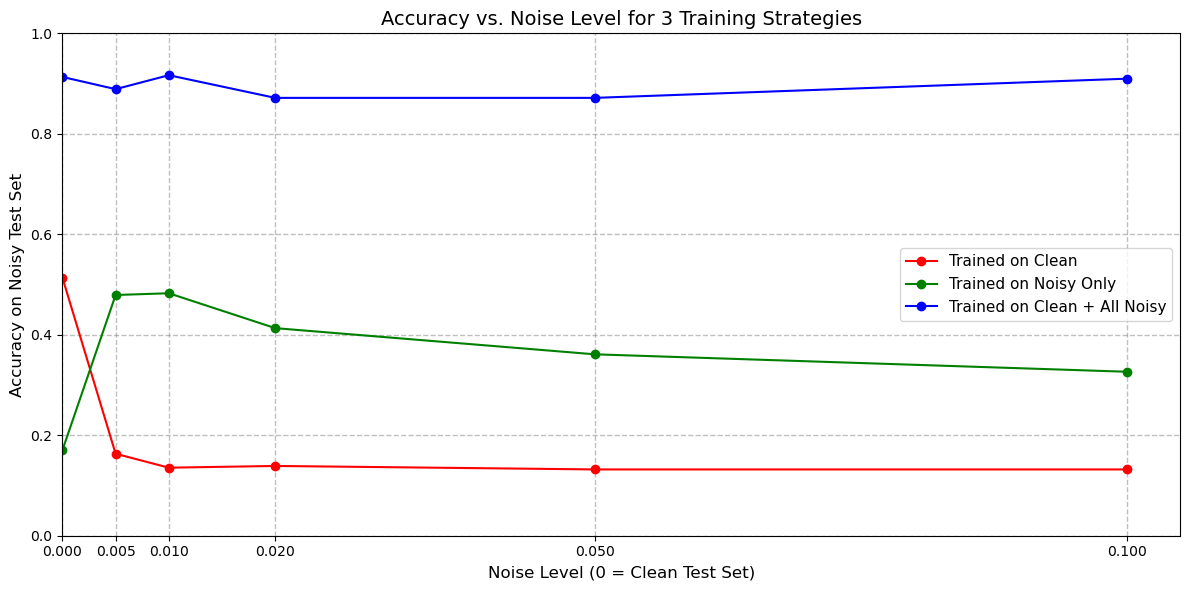

In [61]:
import matplotlib.pyplot as plt

noise_levels_full = [0] + noise_levels

plt.figure(figsize=(12, 6))
plt.plot(noise_levels_full, acc_clean_trained, marker='o', color='red', label='Trained on Clean')
plt.plot(noise_levels_full, acc_noisy_trained, marker='o', color='green', label='Trained on Noisy Only')
plt.plot(noise_levels_full, acc_all_trained, marker='o', color='blue', label='Trained on Clean + All Noisy')

# Labels and formatting
plt.title("Accuracy vs. Noise Level for 3 Training Strategies", fontsize=14)
plt.xlabel("Noise Level (0 = Clean Test Set)", fontsize=12)
plt.ylabel("Accuracy on Noisy Test Set", fontsize=12)
plt.xticks(noise_levels_full, [f"{lvl:.3f}" for lvl in noise_levels_full], fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.xlim(left=0)  # ✅ Start x-axis at 0 exactly
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=1, alpha=0.5, color='gray')
plt.legend(fontsize=11, loc='center right')
plt.tight_layout()

plt.show()
